
## Results show modified gjr works best (for MS)
```jupyterpython
    am=ARX(df, rescale=False, lags=[1,5,22], constant=True)
    am.volatility = GARCH(1,1,1)
    am.distribution = StudentsT()


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 10))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.myuseq.cnf'})
conn = engine.connect()

In [3]:
import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_close from useq.USEQ_HIST where symbol='MS'
    and volume>0 order by tradedate''',
    conn,
    index_col='tradedate'
)

df = pd.DataFrame(SQL_query, columns=['pct_close'])

df.head()


,pct_close
tradedate,
2001-01-02,-8.99684
2001-01-03,16.04270
2001-01-04,5.97443
2001-01-05,-4.58902
2001-01-08,-1.47719


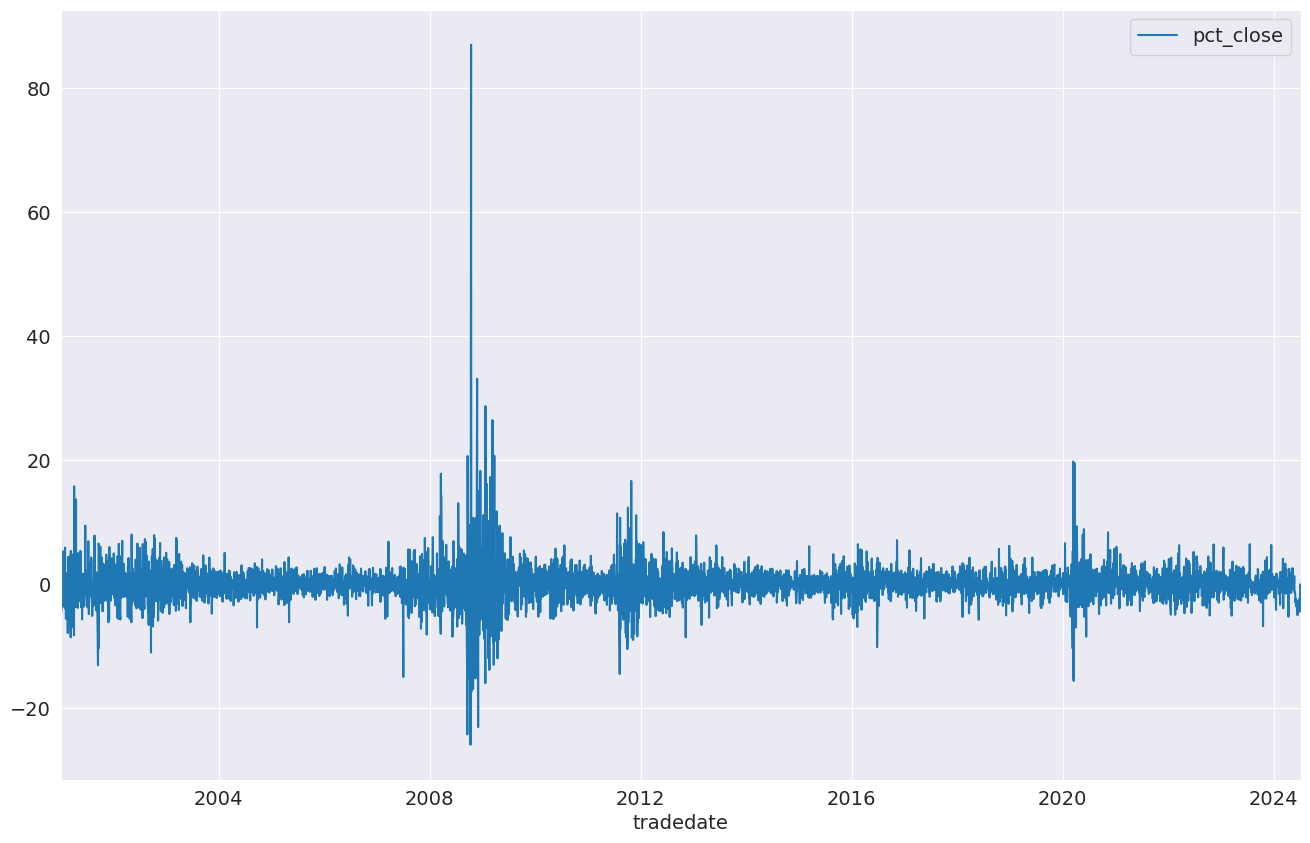

In [4]:
ax = df.plot()
xlim = ax.set_xlim(df.index.min(), df.index.max())


In [5]:
from arch import arch_model

am = arch_model(df, rescale=False, p=1, o=1, q=1, dist="StudentsT")
resg = am.fit(update_freq=5)
print(resg.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: 21924.382160778034
Iteration:     10,   Func. Count:     83,   Neg. LLF: 12990.167759124397
Iteration:     15,   Func. Count:    123,   Neg. LLF: 12486.595273248011
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12486.595259399071
            Iterations: 17
            Function evaluations: 137
            Gradient evaluations: 17
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -12486.6
Distribution:      Standardized Student's t   AIC:                           24985.2
Method:                  Maximum Likelihood   BIC:                           25025.3
                                              No. Observatio

In [6]:
#fig = res.plot(annualize="D")

In [7]:
from arch.univariate import ARX, HARX, HARCH, GARCH, StudentsT, SkewStudent

am=ARX(df, rescale=False, lags=[1,5,22], constant=True)
am.volatility = GARCH(1,1,1)
am.distribution = StudentsT()
resx = am.fit(update_freq=5)
print(resx.summary())

Iteration:      5,   Func. Count:     64,   Neg. LLF: 13795.018856372672
Iteration:     10,   Func. Count:    122,   Neg. LLF: 12482.939929588225
Iteration:     15,   Func. Count:    177,   Neg. LLF: 12423.967636069952
Iteration:     20,   Func. Count:    229,   Neg. LLF: 12420.57975518535
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12420.579754447343
            Iterations: 21
            Function evaluations: 239
            Gradient evaluations: 21
                            AR - GJR-GARCH Model Results                            
Dep. Variable:                    pct_close   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -12420.6
Distribution:      Standardized Student's t   AIC:                           24859.2
Method:                  Maximum Likelihood   BIC:                       

In [8]:
am.distribution = SkewStudent()
resk = am.fit(update_freq=5)
print(resk.summary())

Iteration:      5,   Func. Count:     69,   Neg. LLF: 98962.0429815566
Iteration:     10,   Func. Count:    130,   Neg. LLF: 15040.91379405221
Iteration:     15,   Func. Count:    191,   Neg. LLF: 12470.833852958574
Iteration:     20,   Func. Count:    249,   Neg. LLF: 12420.566751365639
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12420.562361059896
            Iterations: 24
            Function evaluations: 292
            Gradient evaluations: 24
                               AR - GJR-GARCH Model Results                              
Dep. Variable:                         pct_close   R-squared:                       0.001
Mean Model:                                   AR   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -12420.6
Distribution:      Standardized Skew Student's t   AIC:                           24861.1
Method:                       Maximum Likelihood  

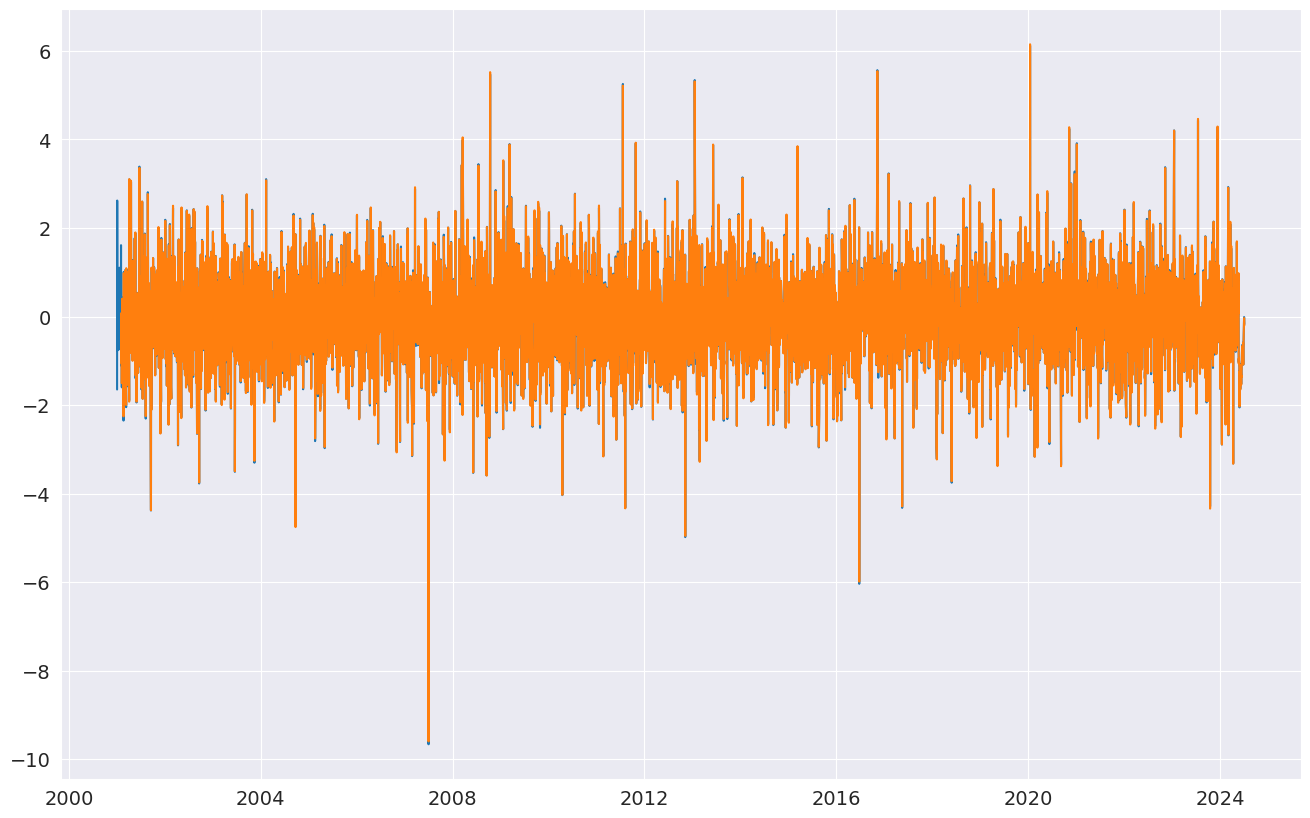

In [9]:
plt.plot(resg.std_resid, label='GJR')
plt.plot(resx.std_resid, label='ARX')

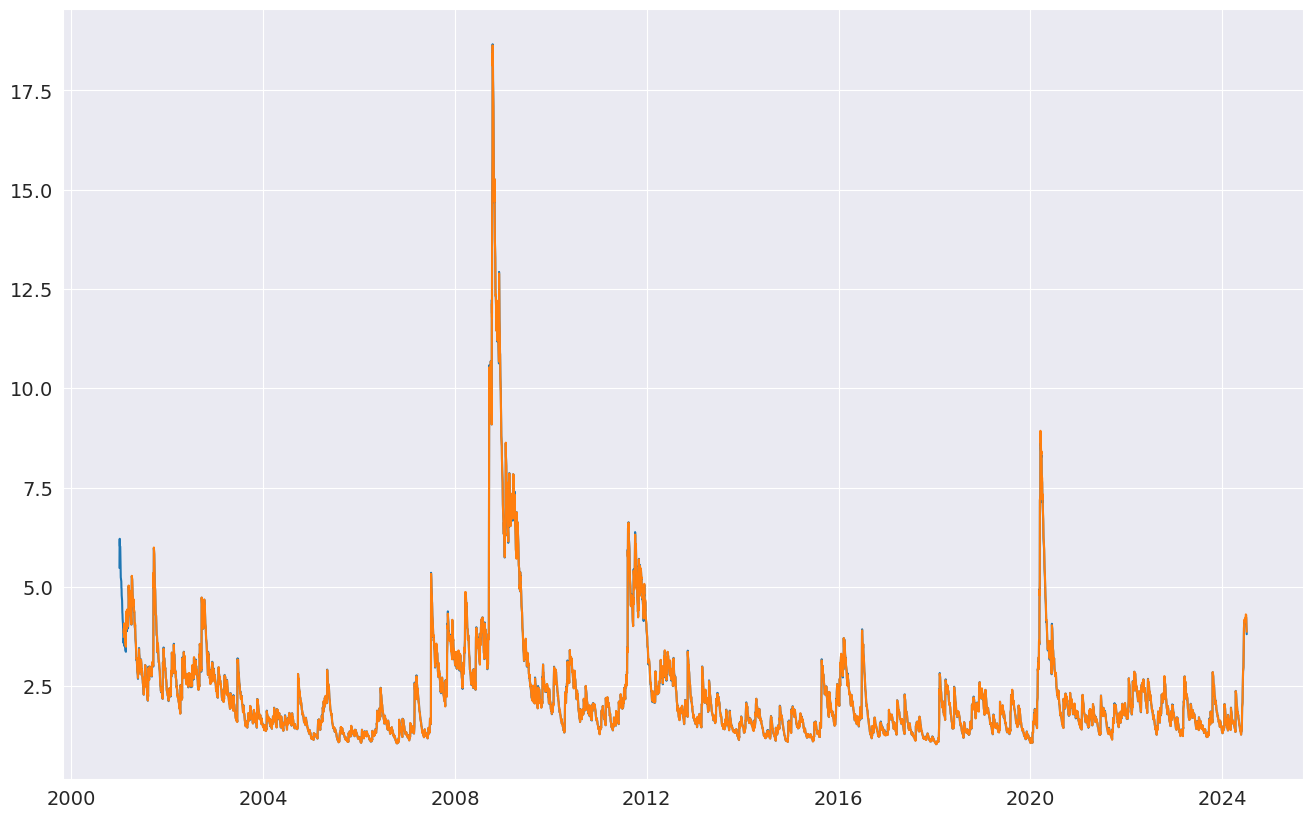

In [10]:
ax = plt.plot(resg.conditional_volatility, label='GJR')
plt.plot(resx.conditional_volatility, label='ARX')

In [11]:
am.volatility = HARCH(lags=[1,5,22])
am.distribution = StudentsT()
res = am.fit(update_freq=5)
print(res.summary())
am.distribution = SkewStudent()
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     66,   Neg. LLF: 35655.26731368444
Iteration:     10,   Func. Count:    124,   Neg. LLF: 12519.257709798556
Iteration:     15,   Func. Count:    177,   Neg. LLF: 12487.634775737155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12487.63415194923
            Iterations: 18
            Function evaluations: 206
            Gradient evaluations: 18
                              AR - HARCH Model Results                              
Dep. Variable:                    pct_close   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            HARCH   Log-Likelihood:               -12487.6
Distribution:      Standardized Student's t   AIC:                           24993.3
Method:                  Maximum Likelihood   BIC:                           25053.4
                                              No. Observations

In [12]:
print("Log-Likelihood = ", resg.loglikelihood, " for GJR")
print("Log-Likelihood = ", resx.loglikelihood, " for ARX")
print("nobs = ", resg.nobs, " for GJR")
print ("nobs = ", resx.nobs, " for ARX")
factor = resg.nobs / resx.nobs
adjusted = resx.loglikelihood * factor
print("Log-Likelihood adjusted = ", adjusted, " for ARX")


Log-Likelihood =  -12486.595259399071  for GJR
Log-Likelihood =  -12420.579754447343  for ARX
nobs =  5913  for GJR
nobs =  5891  for ARX
Log-Likelihood adjusted =  -12466.96453709848  for ARX
